<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/Nifty_Crude_corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [2]:
data = pd.read_csv('/content/crude.csv')

In [3]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [4]:
del data['time']

In [5]:
data= data.set_index('date')



In [6]:
data.head(2)

,open,high,low,close,"CRUDEOIL1!, MCX: Open","CRUDEOIL1!, MCX: High","CRUDEOIL1!, MCX: Low","CRUDEOIL1!, MCX: Close",Volume,Volume MA
date,,,,,,,,,,
16-04-2015,8757.0498,8760.0000,8645.6504,8706.7002,3512.0,3580.0,3435.0,3559.0,NaN,NaN
17-04-2015,8698.0498,8699.8496,8596.7002,8606.0000,3536.0,3554.0,3481.0,3494.0,NaN,NaN


In [7]:
data=data['29-05-2018':]

In [8]:
data.tail(2)

,open,high,low,close,"CRUDEOIL1!, MCX: Open","CRUDEOIL1!, MCX: High","CRUDEOIL1!, MCX: Low","CRUDEOIL1!, MCX: Close",Volume,Volume MA
date,,,,,,,,,,
24-01-2022,17575.15,17599.40,16997.85,17149.1,6349.0,6415.0,6136.0,6240.0,NaN,NaN
25-01-2022,17001.55,17309.15,16836.80,17276.7,6250.0,6328.0,6244.0,6324.0,NaN,NaN


In [9]:
data_subset = data[['close','CRUDEOIL1!, MCX: Close']]

In [10]:
data_subset.columns=['close','close1']


In [11]:
data_subset.head(2)

,close,close1
date,,
29-05-2018,10633.30,4527.0
30-05-2018,10614.35,4614.0


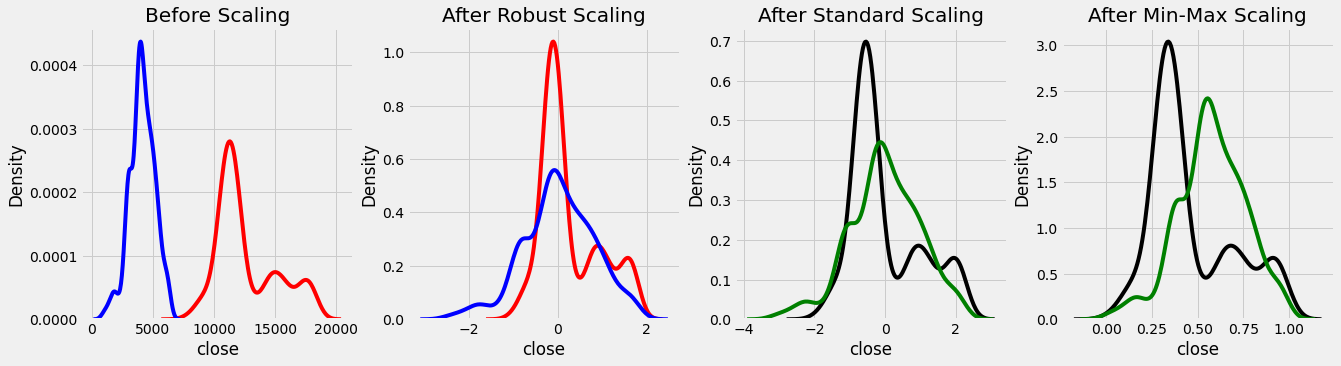

In [12]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


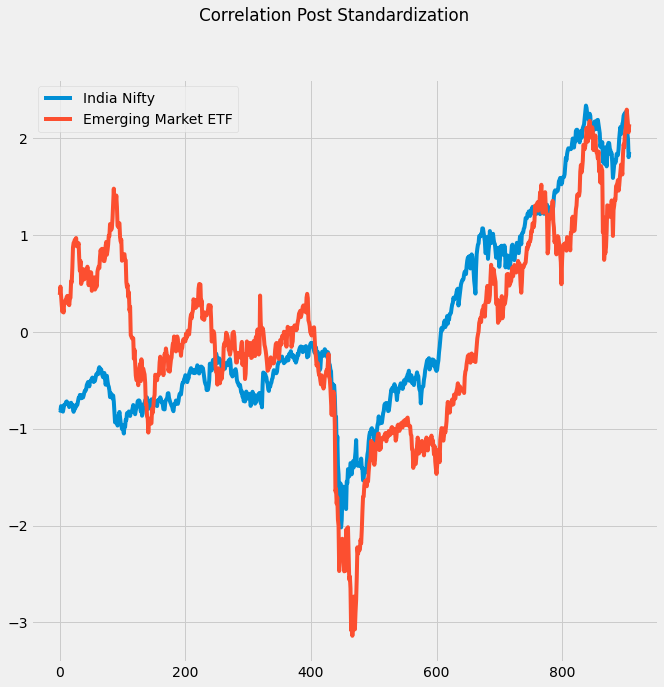

In [13]:
columns=['India Nifty','Emerging Market ETF']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

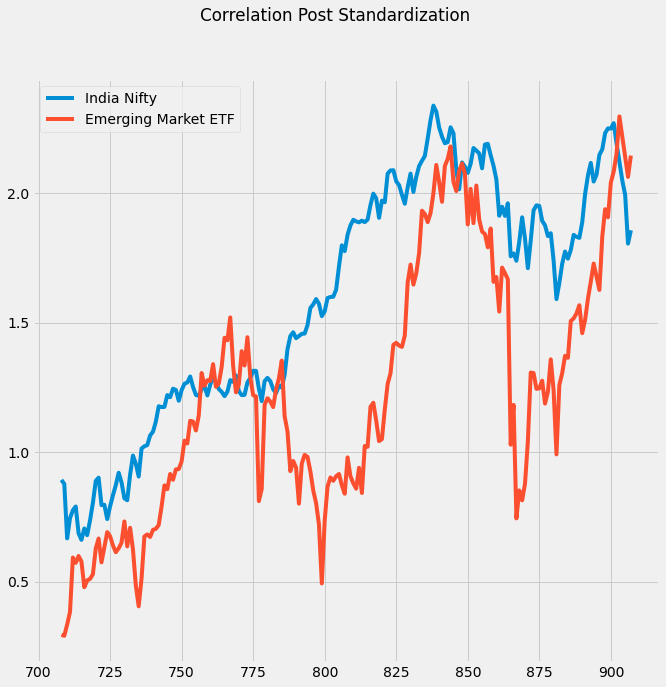

In [14]:
standard_df.columns=columns
standard_df[-200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

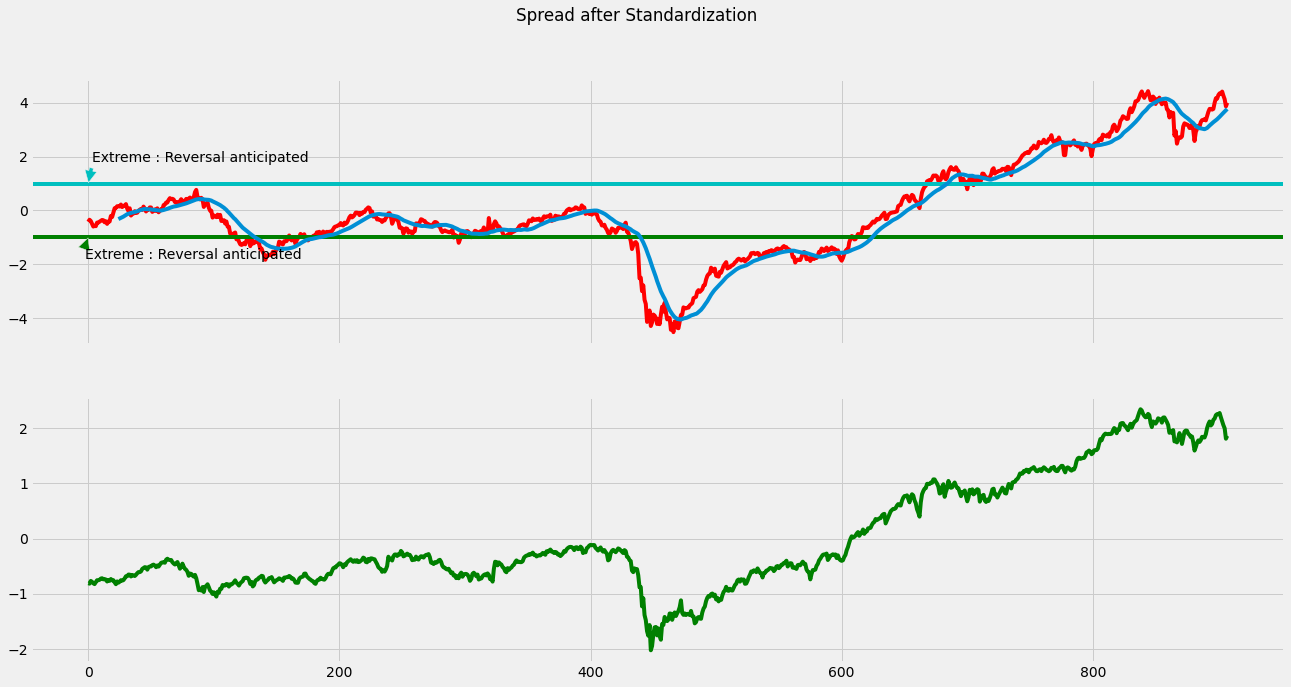

In [15]:
standard_df['diff']=standard_df['India Nifty']+standard_df['Emerging Market ETF']
standard_df['mov_avg']=standard_df['diff'].rolling(window=25).mean()
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r')
ax[1].plot(standard_df['India Nifty'],color='g')
ax[0].axhline(y=1,color='c')
ax[0].axhline(y=-1,color='g')
plt.suptitle('Spread after Standardization')
ax[0].annotate('Extreme : Reversal anticipated', xy =(0, 1),
             xytext =(3, 1.8),
             arrowprops = dict(facecolor ='c',
                               shrink = 0.05),   )
ax[0].annotate('Extreme : Reversal anticipated', xy =(0,-1),
             xytext =(-3, -1.8),
             arrowprops = dict(facecolor ='g',
                               shrink = 0.05),   )
ax[0].plot(standard_df['mov_avg'])
plt.show()


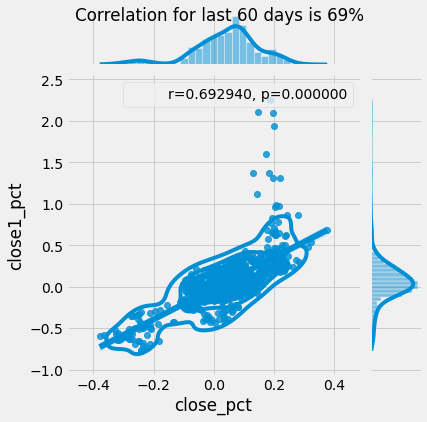

In [16]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()